# Figure 4bcd

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))

# Change path to match location of PPC datasets
# Datasets are available from the Harvey lab
import ppc_data_loader
ppc_data_loader.path = '/home/mrule/Workspace2/PPC_data/'

# Import PPC libraries
from ppc_data_loader   import *
from ppc_trial         import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%matplotlib inline
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE])
matplotlib.rcParams['figure.dpi']=150
plt.rcParams['image.cmap'] = 'extended'
figure() # Check that Matplotlib really did load (bug workaround?)
print('Matplotlib configured')

Matplotlib configured


<Figure size 900x600 with 0 Axes>

## Survey available data: identify longer streaches of consecutive days

In [8]:
consecutive_summary = {}
for animal in get_subject_ids():
    consecutive_summary[animal] = get_consecutive_recordings(animal,130,4)
    release_files(clear_cache=True)
    
print('I will check these spans of days:')
to_check = defaultdict(list)
for animal,spans in consecutive_summary.items():
    for (start,stop),units in spans.items():
        to_check[animal].append(list(arange(start,stop+1)))
to_check = dict(to_check)
for a,ss in to_check.items():
    print('  Mouse %d:'%a)
    for s in ss:
        print('    ',s)

Testing subject 1
  Available sessions 1 2 3 4 5 6 7 10 14 15 20 28 29 32 34 39 41 42 46 48 52
  There are 10 spans at least 4 days long; of these…
  There are 1 spans with at least 130 neurons:
  	04-07 (4 days, 186 neurons)
Testing subject 2
  Available sessions 1 2 3 4 5 10 15 20
  There are  3 spans at least 4 days long; of these…
  There are 0 spans with at least 130 neurons:
Testing subject 3
  Available sessions 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 30 35 42
  There are 210 spans at least 4 days long; of these…
  There are 9 spans with at least 130 neurons:
  	01-06 (6 days, 144 neurons)
  	02-07 (6 days, 132 neurons)
  	04-09 (6 days, 141 neurons)
  	05-10 (6 days, 142 neurons)
  	06-12 (7 days, 134 neurons)
  	09-14 (6 days, 134 neurons)
  	13-19 (7 days, 146 neurons)
  	14-20 (7 days, 130 neurons)
  	16-22 (7 days, 136 neurons)
Testing subject 4
  Available sessions 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 25
  There are 171 spans at l

In [9]:
@memoize
def prepare_data(animal,sessions,predict,PRETRAIN):
    units,uidxs = get_units_in_common(animal,sessions)
    Xtnt = []
    Ytnt = []
    for s in sessions[:PRETRAIN]:
        f  = get_dFF(animal,s)[:,units]
        k  = kininfo[predict]['get'](animal,s)
        Xtnt += [add_constant(x) for x in extract_in_trial(f,animal,s)]
        Ytnt += extract_in_trial(k,animal,s)
    Xtst = []
    Ytst = []
    sameday = {s:{} for s in sessions[PRETRAIN:]}
    for s in sessions[PRETRAIN:]:
        f  = get_dFF(animal,s)[:,units]
        k  = kininfo[predict]['get'](animal,s)
        x  = [add_constant(x) for x in extract_in_trial(f,animal,s)]
        y  = extract_in_trial(k,animal,s)
        Xtst += x
        Ytst += y
        # Also get single-day performance
        yd = trial_crossvalidated_least_squares(x,y,10,shuffle=True)[1]
        ed = np.concatenate(y) - yd
        ad = mean(abs(ed))
        sameday[s]['e'] = ed
        sameday[s]['mabse'] = ad
        sameday[s]['yh'] = yd
    return Xtnt,Ytnt,Xtst,Ytst,sameday

# LMS with limits on the weight changes

## Initial estimate of reasonable weight-change limits to serch over

In [10]:
animal   = 4
sessions = tuple(arange(2,14))
units    = get_units_in_common(animal,sessions)[0]
NDAYS    = len(sessions)
PRETRAIN = 2
predict  = 1
NXVAL    = 10
slens = [len(concatenate(extract_in_trial(get_dFF(animal,s)[:,0],animal,s))) for s in sessions]
print('%d units in common'%len(units))

# Get data
Xtnt,Ytnt,Xtst,Ytst,samedayperf = prepare_data(animal,sessions,predict,PRETRAIN)
Xtrain = concatenate(Xtnt)
Ytrain = concatenate(Ytnt)
Xtest  = concatenate(Xtst)
Ytest  = concatenate(Ytst)

# Concatenated baseline
yc = trial_crossvalidated_least_squares(Xtst,Ytst,NXVAL,shuffle=True)[1]
ec = Ytest - yc
ac = mean(abs(ec))

# Pretrain
w0  = reglstsq(Xtrain,Ytrain)

# Number of timepoints
T      = Xtest.shape[0]

# Number of testing sessions
# (total sessions minus those used for initialization)
D      = len(sessions)-PRETRAIN

# Average weight magnitude from OLS training
wbar   = mean(abs(w0))

# Limits on instantaneous weight change,
# in units of percent per session
dpcts  = array([2,5,10,20,50,100,200,500,1000,2000,4000])

# Learning rates to check (grid search)
rates  = concatenate([[0],10**linspace(-6,log10(0.011),20)])

# Limits on instantaneous weight change,
# in units of Δweight/sample
deltas = dpcts*wbar/100*D/T

144 units in common


In [11]:
def run_LMS(X,Y,w0=None,rate=1,reg=1e-12,normalized=False,delta=None,clip=None):
    '''
    
    Parameters
    ----------
    X: array-like; Nsamples x Nfeatures
        Independent/input variables
    Y: array-like; Nsamples x Noutputs
        Dependent/output variables
    
    Other Parameters
    ----------------
    w0: array-like
        Initial parameter weighers
    rate: scalar, default 1
        Learning rate
    reg: scalar, default 1e-12
        L2 regularization penalty to shrink weight
    normalized: bool, default True
        Whether to run the Normalized LMS
    delta: positive scalar, default is None
        If not `None`, we will report not the true weights
        but teh result of a process that attempts to track
        the true rates, with a limit of `delta` change per 
        timestep. This is not used in the paper. In theory,
        this would correspond to a slow process (e.g. 
        synaptic size change), while the actual fast changes
        in synaptic strength are handled by some other 
        process. Instead, we report the total change over
        on session to summarize the rate of slow weight 
        change required.
    clip: positive scalar, default is None
        If not `None`, then weight changes will be limited
        to be no larger than this value (up to floating point
        accuracy).

    Returns
    -------
    all_w:
        Weights over time
    all_e;
        Errors over time
    all_yh:
        Predicted kinematics over time
    '''
    X = np.array(X)
    Y = np.array(Y)
    if len(Y.shape)==1:
        Y = array([Y]).T
    rate  = np.float32(rate)
    if not delta is None:
        delta = np.abs(np.float32(delta))
    if not clip  is None:
        clip  = np.abs(np.float32(clip))
    Nsamples   = Y.shape[0]
    Nfeatures  = X.shape[1]
    Nkinematic = Y.shape[1]
    # Initial weights
    w = zeros((Nfeatures,Nkinematic)) if w0 is None\
        else np.array(w0).reshape((Nfeatures,Nkinematic))
    # Tracking weights
    u = w.copy()
    # Store a history of weights, errors, and decoder estiamtes
    all_w  = zeros((Nsamples+1,Nfeatures,Nkinematic))
    all_e  = zeros((Nsamples,Nkinematic))
    all_yh = zeros((Nsamples,Nkinematic))
    all_w[0] = w
    # Shrinkage penalty
    λ = exp(-reg)
    # Run LMS algorithm
    for t in range(Nsamples):
        x    = X[t:t+1] # 1×Nfeat; intput features
        y    = Y[t:t+1] # 1×Nkine; decoded kinematics
        yh   = x @ w    # 1×Nfeat∙Nfeat×Nkine; prediction
        e    = y-yh     # 1×Nkine; errors
        # 1x1; weight update strength (normalized)
        α    = (rate/x @ x.T) if normalized else rate 
        dw   = (α*x.T@ e) # Nfeat×1∙1×Nkine; weight update
        # L2 regularizing potential
        dw = (w+dw)*λ-w
        # Clipped weight updates
        w   += dw if clip is None else np.clip(dw,-clip,clip)
        # Clipped tracking
        u = w if delta is None else u+np.clip(w-u,-delta,delta)
        all_w [t+1] = u
        all_e [t  ] = e
        all_yh[t  ] = yh
        if not clip is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=clip*(1+1e-7)))
        if not delta is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=delta*(1+1e-7)))
    if not delta is None:
        all_yh = np.sum(X[:,:,None] * all_w[:-1],axis=1)
        all_e  = Y - all_yh
    all_w = all_w[1:]

    return all_w,all_e,all_yh

def test_LMS_summary(X,Y,w0,sessions,rate,polar_error=False,reg=1e-12,delta=None,clip=None):
    '''
    Test least mean-squares, returning the weights as well as the
    statistical summary information. 
    '''
    X,T = np.array(X),np.array(Y)
    if len(Y.shape)==1: Y=array([Y]).T
    w,e,yh  = run_LMS(X,Y,w0,
        rate       = rate,
        reg        = reg,
        normalized = False,
        delta      = delta,
        clip       = clip)
    NDAYS = len(sessions)
    sampd = (X.shape[0]/(NDAYS-1))
    RMSW  = np.sqrt(np.mean(w[:,:,0]**2))
    MABSW = np.mean(abs(w[:,:,0]))
    dw    = np.diff(w[:,:,0],axis=0)
    RMSD  = np.sqrt(np.mean(dw**2))
    RMSE, MABSE = polar_error_degrees(Y,yh) if polar_error else\
                  np.sqrt(np.mean(np.abs(e)**2)),np.mean(np.abs(e))
    MABSD = np.mean(np.abs(dw))
    MAXD  = np.max (np.abs(dw))
    if not clip is None:
        if np.any(np.abs(dw)>clip*(1+1e-6)):
            raise ValueError('!!!!Sanity-check failed: some Δw larger than clip value of %f!!!!'%clip)
        assert(MAXD<clip*(1+1e-6))
        assert(MABSD<clip*(1+1e-6))
    return {
        'RMSY' :np.std(Y),
        'MABSY':np.mean(np.abs(Y)),
        'RMSE' :RMSE,
        'MABSE':MABSE,
        'RMSW' :RMSE,
        'MABSW':MABSW,
        'RMSD' :RMSD,
        'MABSD':MABSD,
        'MAXD' :MAXD
    }

def delta_rate_scan_helper(params):
    i,(rate,delta) = params
    result = test_LMS_summary(Xtest,Ytest,w0,sessions,rate,predict==4,clip=delta)
    return i,result
release_files(clear_cache=True)
reset_pool()



# Summarize multiple

### Compute scans over rates and allowed Δ if they are not already saves

In [12]:
def delta_rate_scan_helper(params):
    i,(Xtest,Ytest,w0,sessions,rate,delta) = params
    return i,test_LMS_summary(Xtest,Ytest,w0,sessions,rate,predict==4,clip=delta)

@memoize
def scan_deltas_and_rates(animal,sessions,predict,PRETRAIN,NXVAL=10):
    print('Processing',kininfo[predict]['name'])
    # Get data
    Xtnt,Ytnt,Xtst,Ytst,samedayperf = prepare_data(animal,sessions,predict,PRETRAIN)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    # Concatenated baseline
    yc = trial_crossvalidated_least_squares(Xtst,Ytst,NXVAL,shuffle=True)[1]
    ec = Ytest - yc
    ac = mean(abs(ec))
    # Pretraining error baseline and initial weights
    w0     = reglstsq(Xtrain,Ytrain)
    e01    = mean(abs(Ytest-Xtest @ w0))
    # Maximum allowed weight change
    T      = Xtest.shape[0]
    D      = len(sessions)-PRETRAIN
    wbar   = mean(abs(w0))    
    deltas = dpcts*wbar/100*D/T
    # For each plasticity limit, scan over several rates
    # (we will pick the one with lowest error)
    release_files(clear_cache=True)
    reset_pool()
    delta_rates = parmap(delta_rate_scan_helper,enumerate([
                (Xtest,Ytest,w0,sessions,rate,delta) 
                for rate in rates 
                for delta in deltas]),
                         debug=False)
    return {
        'deltas'     :deltas,
        'delta_rates':delta_rates,
        'ac'         :ac,
        'e01'        :e01,
        'w0'         :w0,
        'wbar'       :wbar,
    }

In [13]:
# Store results to plot later
print('Starting...')
delta_rates_saved = {}
for ip,predict in enumerate([1,3,4]):
    delta_rates_saved[predict] = scan_deltas_and_rates(animal,sessions,predict,PRETRAIN,NXVAL)
print('Done')

Starting...
Done


### Plot the results

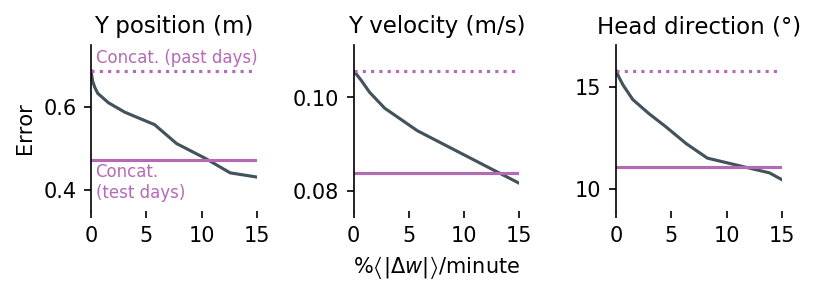

In [14]:
%matplotlib inline 
matplotlib.rcParams['figure.dpi']=150
figure(figsize=(5.5,2))
xlimit = 15
FS = get_FS(animal,sessions[0]) # Sampling rate
for ip,predict in enumerate([1,3,4]):
    subplot(1,3,ip+1)
    delta_rates = delta_rates_saved[predict]['delta_rates']
    e01         = delta_rates_saved[predict]['e01']
    ac          = delta_rates_saved[predict]['ac']
    w0          = delta_rates_saved[predict]['w0']
    wbar        = delta_rates_saved[predict]['wbar']
    dr = array([r['MABSE'] for r in delta_rates]).reshape((len(rates),len(deltas)))
    pd = array([r['MABSD'] for r in delta_rates]).reshape((len(rates),len(deltas)))/wbar*100*FS*60
    # Pick learning rate with minimum error for given level 
    # of plasticity limit
    pp  = concatenate([[0  ],[p[argmin(e)] for p,e in zip(pd.T,dr.T)]])
    ee  = concatenate([[e01],[np.min(e)    for p,e in zip(pd.T,dr.T)]])
    plot(pp,ee)
    simpleraxis()
    if ip==1:
        xlabel('%${\\left<|\Delta w|\\right>}/$minute')
    if ip==0:
        ylabel('Error')
    title('%s (%s)'%(kininfo[predict]['name'],kininfo[predict]['units']),fontsize=11)
    y0  = min(ac,np.min(ee[pp<=xlimit]))
    pad = (e01-y0)*0.25
    ylim(y0-pad*1.5,e01+pad)
    xlim(0,xlimit)
    x   = pixels_to_xunits(5)
    y   = e01
    dy  = pixels_to_yunits(5)
    axhline(y,color=MAUVE,linestyle=':')
    if ip==0:
        text(x,y+dy,'Concat. (past days)',ha='left',va='bottom',color=MAUVE,fontsize=8)
    y = ac
    axhline(y,color=MAUVE)
    if ip==0:
        text(x,y-dy,'Concat.\n(test days)',ha='left',va='top',color=MAUVE,fontsize=8)
    xticks([0,5,10,15])
    force_aspect()
tight_layout() 
savefigure('constrained_LMS_rate_optimization_v3')

# Illustrative examples

In [15]:
predict = 1
nrates  = len(rates)
ndeltas = len(deltas)

# These were computed with the command
# test_LMS_summary(Xtest,Ytest,w0,sessions,rate,predict==4,clip=delta,reg=0)
# Rate is the learning rate
# "clip" limits the weight changes per sample

# These are the weight change tolerances computed 
# based on the allowed % change and the average |w| for the
# concatenated fit.
wbar   = delta_rates_saved[predict]['wbar']
deltas = delta_rates_saved[predict]['deltas']

# These are the results of LMS
delta_rates = delta_rates_saved[predict]['delta_rates']

# This is the mean absolute reconstruction error
dr = array([r['MABSE'] for r in delta_rates]).reshape((nrates,ndeltas))

# This is the average Δw per timestep
# We convert it to %|Δw|/session units
pd = array([r['MABSD'] for r in delta_rates]).reshape((nrates,ndeltas))/wbar*100*T/D
# Sanity check that average Δw is less than the maximum specified
if not np.all(pd<=outer(ones(nrates),dpcts*(1+1e-4))):
    print('Average |Δw| exceed the maximum Δw specified for some runs, this should not happen!')

# This is the maximum Δw per timestep
# We convert it to %|Δw|/session units
md = array([r['MAXD'] for r in delta_rates]).reshape((nrates,ndeltas))/wbar*100*T/D
# Sanity check that average Δw is less than the maximum specified
if not np.all(md<=outer(ones(nrates),dpcts*(1+1e-4))):
    print('Maximum |Δw| exceed the maximum Δw specified for some runs, this should not happen!')


Target <|w|> =    0.26453
Actual <|w|> =    0.24669
max%Δw       =  100.00000
Δw limit     =    0.00054
peak %Δ/ses  = 2000.00000
learn rate   =    0.00022
<|Δw|>%      =   54.96079
error        =    0.51131
Learning rate corresponds to time constant of 14.381998 minutes
Used these sessions: (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)
144 neurons
12 days
Pre-trained on first 2 sessions
%Δw/s limit is 1.087581
%Δw/s limit is 1.166241


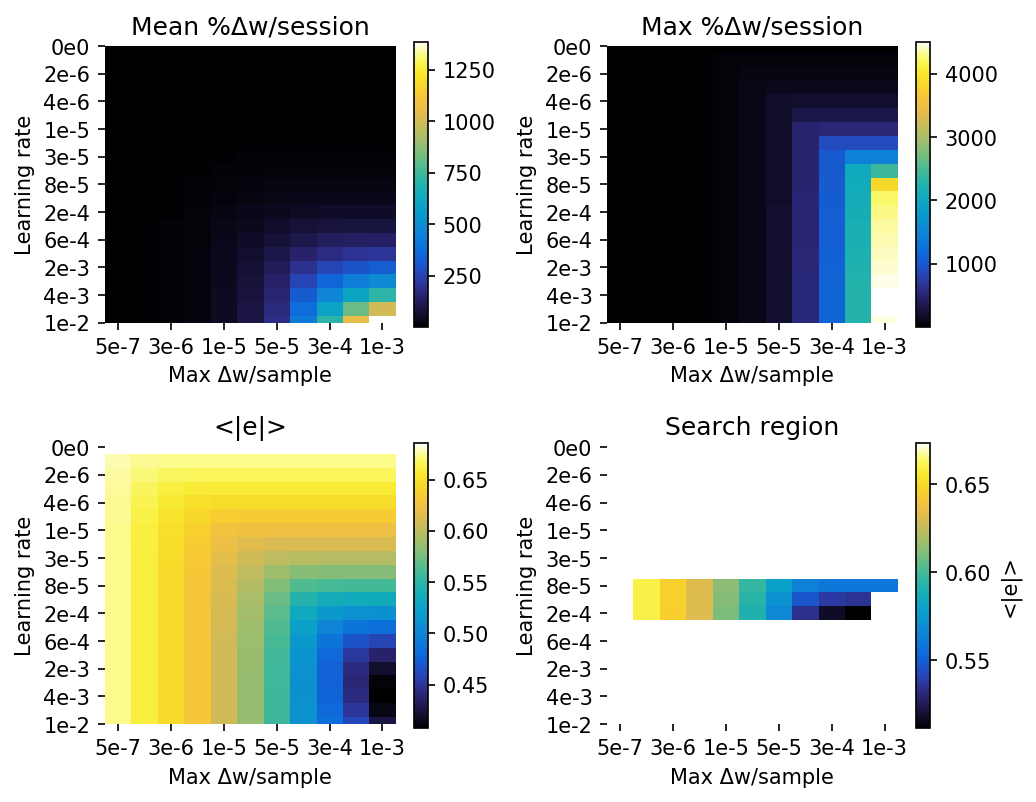

In [16]:
# Average weight magnitude
mw = array([r['MABSW'] for r in delta_rates]).reshape((nrates,ndeltas))
# Average weight change
dw = array([r['MABSD'] for r in delta_rates]).reshape((nrates,ndeltas))
# Peak weight change
xw = array([r['MAXD'] for r in delta_rates]).reshape((nrates,ndeltas))
meandwpct = dw/mw*100*T/D
peakdwpct = xw/mw*100*T/D

# Restrict search 
FS                     = get_FS(animal,sessions[0])
maxpctpersession       = 100
maxpcttransient        = 4000
maxtimeconstantminutes = 60
mintimeconstantminutes = 10
time_constants_minutes = 1/(rates+1e-13)/FS/60
time_constants_minutes = outer(time_constants_minutes,ones(len(deltas)))

# Select the rate and plasticity limit that leads to 
# no more than 100% average change per session
ok = (meandwpct.ravel()<=maxpctpersession)\
    &(peakdwpct.ravel()<=maxpcttransient)\
    &(time_constants_minutes.ravel()<maxtimeconstantminutes)\
    &(time_constants_minutes.ravel()>mintimeconstantminutes)

# minimum error within tolerance
merr  = np.min(dr.ravel()[ok])
ii    = find(ok)[argmin(dr.ravel()[ok])]
di    = ii% len(deltas)
ri    = ii//len(deltas)
delta = deltas[di]
rate  = rates [ri]
mdw   = pd[ri,di]
wbar2 = mw[ri,di]

# Print summar
print('Target <|w|> = %10.5f'%wbar)
print('Actual <|w|> = %10.5f'%mw[ri,di])
print('max%%Δw       = %10.5f'%maxpctpersession)
print('Δw limit     = %10.5f'%delta)
print('peak %%Δ/ses  = %10.5f'%dpcts[di])
print('learn rate   = %10.5f'%rate )
print('<|Δw|>%%      = %10.5f'%mdw  )
print('error        = %10.5f'%merr )
print('Learning rate corresponds to time constant of %f minutes'%(1/rate/FS/60))
# Max instantaneous change much larger than average change
print('Used these sessions:',sessions)
print('%d neurons'%(Xtest.shape[1]-1))
print('%d days'%len(sessions))
print('Pre-trained on first %d sessions'%PRETRAIN)
print('%%Δw/s limit is %f'%(delta*FS*100/wbar))
print('%%Δw/s limit is %f'%(delta*FS*100/wbar2))

# Plot results of search

figure(figsize=(7,5.5))
subplot(221)
imshow(meandwpct,aspect=ndeltas/nrates)
noxyaxes()
colorbar()
xt = arange(0,deltas.shape[0],2)
xl = [shortscientific(x) for x in deltas[xt]]
xticks(xt,xl)
yt = arange(0,rates.shape[0],2)
yl = [shortscientific(x) for x in rates[yt]]
yticks(yt,yl)
ylabel('Learning rate')
xlabel('Max Δw/sample')
title('Mean %Δw/session')

subplot(222)
imshow(peakdwpct,aspect=ndeltas/nrates)
force_aspect()
noxyaxes()
colorbar()
xt = arange(0,deltas.shape[0],2)
xl = [shortscientific(x) for x in deltas[xt]]
xticks(xt,xl)
yt = arange(0,rates.shape[0],2)
yl = [shortscientific(x) for x in rates[yt]]
yticks(yt,yl)
ylabel('Learning rate')
xlabel('Max Δw/sample')
title('Max %Δw/session')

subplot(223)
imshow(dr,aspect=ndeltas/nrates)
force_aspect()
noxyaxes()
colorbar()
xt = arange(0,deltas.shape[0],2)
xl = [shortscientific(x) for x in deltas[xt]]
xticks(xt,xl)
yt = arange(0,rates.shape[0],2)
yl = [shortscientific(x) for x in rates[yt]]
yticks(yt,yl)
ylabel('Learning rate')
xlabel('Max Δw/sample')
title('<|e|>')

subplot(224)
mask = float32(int32(ok.reshape(pd.shape)))
mask[mask!=1]=nan
imshow(dr*mask,aspect=ndeltas/nrates)
noxyaxes()
xt = arange(0,deltas.shape[0],2)
xl = [shortscientific(x) for x in deltas[xt]]
xticks(xt,xl)
yt = arange(0,rates.shape[0],2)
yl = [shortscientific(x) for x in rates[yt]]
yticks(yt,yl)
colorbar(label='<|e|>')
ylabel('Learning rate')
xlabel('Max Δw/sample')
title('Search region')

tight_layout()

## Process result

In [17]:
@memoize
def test_constrained_LMS(animal,sessions,predict,rate,delta,PRETRAIN=2,NXVAL=10):
    Xtnt,Ytnt,Xtst,Ytst,sameday = prepare_data(animal,sessions,predict,PRETRAIN)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    # Concatenated baseline
    yc = trial_crossvalidated_least_squares(Xtst,Ytst,NXVAL,shuffle=True)[1]
    ec = Ytest - yc
    ac = mean(abs(ec))
    # Pretrain baseline
    w0 = reglstsq(Xtrain,Ytrain)
    y0 = Xtest @ w0
    e0 = Ytest - y0
    a0 = mean(abs(ec))
    # LMS performance
    w,e,yh = run_LMS(Xtest,Ytest,w0,rate=rate,clip=delta)
    return {
        'Xtest':Xtest,
        'Ytest':Ytest,
        'sameday':sameday,
        'w' :squeeze(w),
        'e' :squeeze(e),
        'e0':squeeze(e0),
        'ec':squeeze(ec),
        'y' :squeeze(Ytest),
        'yh':squeeze(yh),
        'y0':squeeze(y0)}
    
results = {}
for predict in [1,3,4]:
    results[predict]=test_constrained_LMS(animal,sessions,predict,rate,delta,PRETRAIN,NXVAL)
print('Done')

Done


## Get summary statistics

In [18]:
edges = array([0]+list(cumsum(slens[PRETRAIN:])-2))

for predict in [1,3,4]:
    print('Variable %d'%predict)
    w   = results[predict]['w']
    dw  = abs(diff(w,axis=0))
    maw = np.mean(abs(w))
    print('  Peak %Δw/m      ',np.max( dw)/maw*100*FS*60)
    print('  Mean %Δw/m      ',np.mean(dw)/maw*100*FS*60)
    print('  Peak %Δw/session',np.max( abs(diff(w[edges,:],axis=0)))/maw*100)
    print('  Mean %Δw/session',np.mean(abs(diff(w[edges,:],axis=0)))/maw*100)
    
# Get some summary statistics
print('All variables merged:')
w   = concatenate([results[p]['w'].T                   for p in [1,3,4]]).T
dw  = concatenate([abs(diff(results[p]['w'],axis=0)).T for p in [1,3,4]]).T 
maw = np.mean(abs(w))
print('  Peak %Δw/m      ',np.max( dw)/maw*100*FS*60)
print('  Mean %Δw/m      ',np.mean(dw)/maw*100*FS*60)
print('  Peak %Δw/session',np.max( abs(diff(w[edges,:],axis=0)))/maw*100)
print('  Mean %Δw/session',np.mean(abs(diff(w[edges,:],axis=0)))/maw*100)

Variable 1
  Peak %Δw/m       69.97447422317548
  Mean %Δw/m       1.9229261880370858
  Peak %Δw/session 78.29388355371508
  Mean %Δw/session 7.679159710990035
Variable 3
  Peak %Δw/m       279.6428585447095
  Mean %Δw/m       2.073706010874258
  Peak %Δw/session 76.97498176004139
  Mean %Δw/session 7.957406083561571
Variable 4
  Peak %Δw/m       3.454234662366928
  Mean %Δw/m       1.2189666865755158
  Peak %Δw/session 21.63735769468067
  Mean %Δw/session 3.571207548876665
All variables merged:
  Peak %Δw/m       9.80117444345372
  Mean %Δw/m       1.2582431146393018
  Peak %Δw/session 61.39464685808409
  Mean %Δw/session 3.7958937785418327


## Plot examples

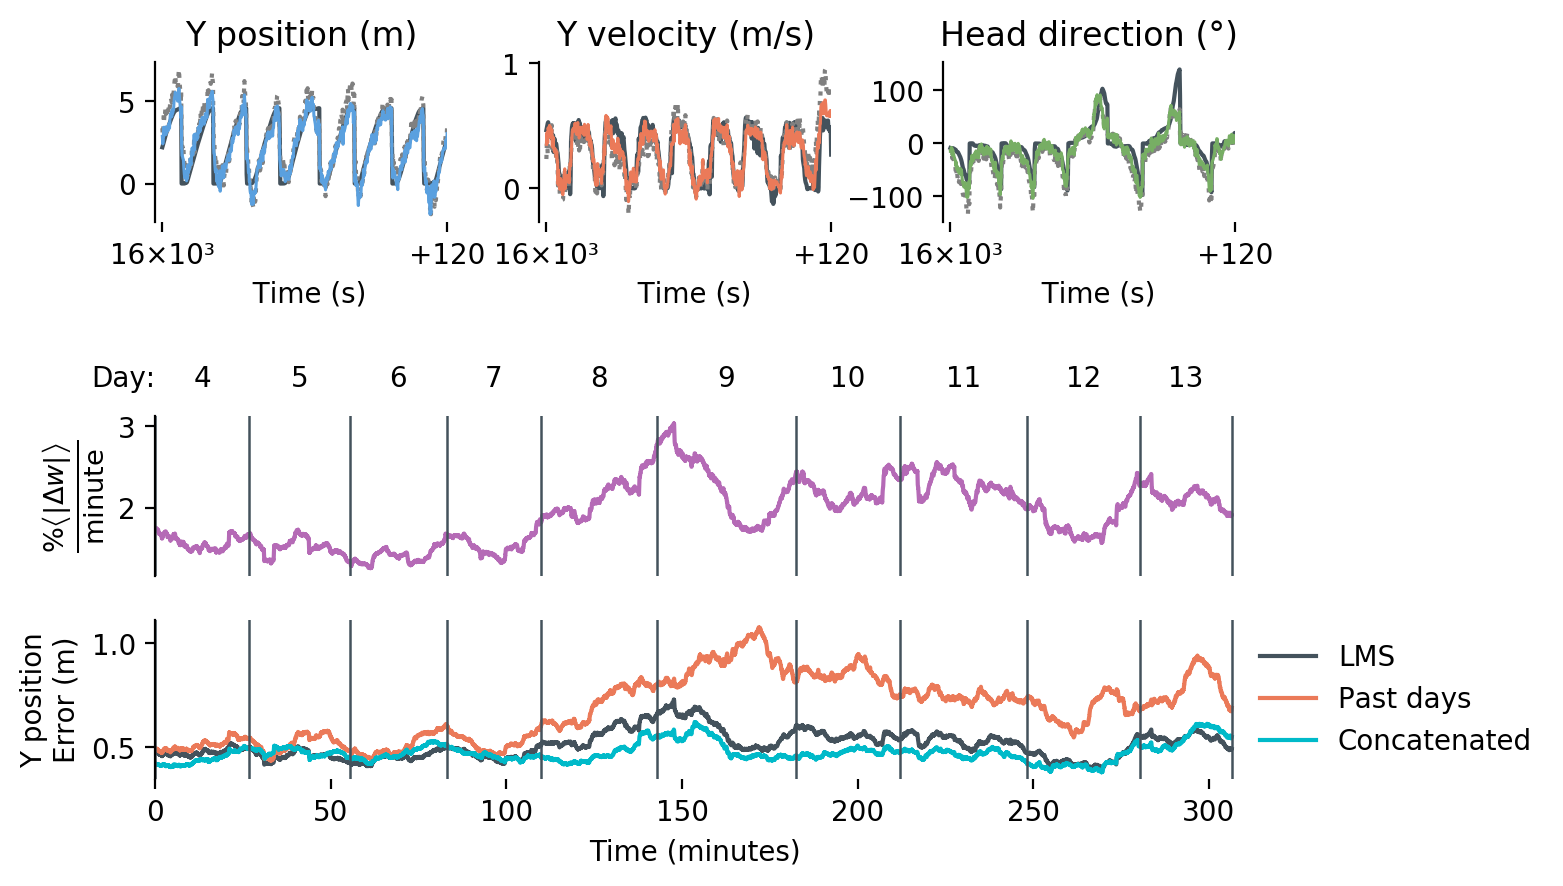

In [19]:
%matplotlib inline
matplotlib.rcParams['figure.dpi']=200

FS = 5.3
dt = 60*2
#t1 = int(round(80000/FS/60)*60*FS)
t1 = int(16000*FS)
t2 = t1 + int(dt*FS)
tt = arange(t1,t2)/FS

def snapshot_plot(p,color=RUST):
    simpleraxis()
    xlabel('  Time (s)')
    title(kininfo[p]['name']+' (%s)'%kininfo[p]['units'])
    plot(tt,results[p]['y'][t1:t2],label='True')
    plot(tt,results[p]['y0'][t1:t2],color=(0.5,0.5,0.5),linestyle=':',label='OLS')
    plot(tt,results[p]['yh'][t1:t2],color=color,lw=1.1,label='LMS')
    xticks([tt[0],tt[-1]],['%d×10³'%(tt[0]//1000),'+%d'%dt])
    #fudgex(5)
    xlim(xlim()[0]-0.025*diff(xlim()),xlim()[1])

figure(figsize=(8,4.75))

ax0 = subplot2grid((3,3),(0,0))
ax1 = subplot2grid((3,3),(0,1))
ax2 = subplot2grid((3,3),(0,2))
ax3 = subplot2grid((3,3),(1,0),1,3)
ax4 = subplot2grid((3,3),(2,0),1,3)

subplots_adjust(wspace=0.35,hspace=0.75,right=0.8)

# Individual examples
sca(ax0)
snapshot_plot(1,color=AZURE)
sca(ax1)
snapshot_plot(3,color=RUST)
nudge_axis_x(-10)
sca(ax2)
snapshot_plot(4,color=MOSS)

# weight updates
sca(ax3)
SMOOTH  = int(FS*60*10)
w       = results[1]['w']#concatenate([results[p]['w'].T for p in [1,3,4]]).T
#dw      = abs(diff(w,axis=0))/mean(abs(w))*100*T/D
dw      = abs(diff(w,axis=0))/np.mean(abs(w))*100*FS*60#*T/(len(sessions)-PRETRAIN)
dwmeans = box_filter(mean(dw,axis=1),SMOOTH)
T       = dw.shape[0]
tt      = arange(T)/FS/60
mm      = dwmeans
plot(tt,mm,color=MAUVE);
simpleraxis()
xlabel('')
ylabel('$\\frac{\%\\left<|\Delta w|\\right>}{\\operatorname{minute}}$',fontsize=14)
xticks([])
edges = tt[array([0]+list(cumsum(slens[PRETRAIN:])-2))]
for t in edges:
    axvline(t,color=BLACK,lw=0.9)
ytext = ylim()[0]+diff(ylim())*1.15
for s,middle in zip(sessions[PRETRAIN:],0.5*(edges[1:]+edges[:-1])):
    text(middle,ytext,'%d'%s,ha='center',va='bottom')
text(0,ytext,'Day:',ha='right',va='bottom')#,fontweight='bold')
nudge_axis_y(-75)
x1 = tt[-1]+1
xlim(0,x1)

# Reconstruction errors
p=1
sca(ax4)
e      = results[p]['e' ]
e0     = results[p]['e0']
ec     = results[p]['ec']
eq     = concatenate([results[p]['sameday'][s]['e'] for s in sessions[PRETRAIN:]])
T      = e.shape[0]
tt     = arange(T)/FS/60
plot(tt,box_filter(abs(e ),SMOOTH),label='LMS')
plot(tt,box_filter(abs(e0),SMOOTH),label='Past days')
plot(tt,box_filter(abs(ec),SMOOTH),label='Concatenated')
#plot(tt,box_filter(abs(eq),SMOOTH),label='Same day')
for t in edges:
    axvline(t,color=BLACK,lw=0.9)
simpleraxis()
xlabel('Time (minutes)')
ylabel('%s\nError (%s)'%(kininfo[p]['name'],kininfo[p]['units']))
xlim(0,x1)
rightlegend()

savefigure('limited_LMS_summary_s%02d_sessions_%02d-%02d'%(animal,sessions[0],sessions[-1]))